# Agrupamento de Dados

>

- Aplicação das técnicas dos algoritmos de agrupamento na base de dados do detecção de fraudes em cartões de créditos e analisar os insights.

## Análise inicial dos dados

> Entendimento do dataset e separação dos dados para treinamento.

### Carregamento e organização do dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from collections import Counter
import pandas as pd

data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/creditcard.csv')
data = data.drop_duplicates()
total = len(data.values)
normal = len(data[data['Class'] == 0])
fraud = len(data[data['Class'] == 1])
fraudpercentage = round((fraud/total)*100, 2)
normalpercentage = round((normal/total)*100, 2)

print('Total de transações:', total)
print('Total de transações legítimas:', normal)
print('Total de transações fraudulentas:', fraud)
print('Porcentagem de transações legítimas:', normalpercentage, '%')
print('Porcentagem de transações fraudulentas:', fraudpercentage, '%')

data.head()

Total de transações: 283726
Total de transações legítimas: 283253
Total de transações fraudulentas: 473
Porcentagem de transações legítimas: 99.83 %
Porcentagem de transações fraudulentas: 0.17 %


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Separação dos dados para treinamento

Training set:
0    226597
1       383
Name: Class, dtype: int64


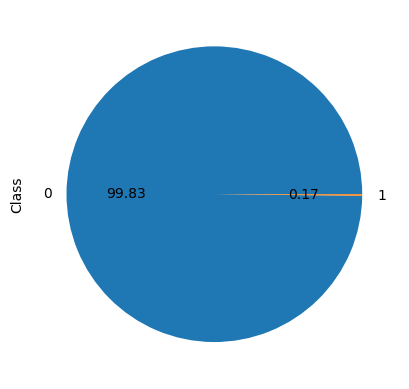

In [ ]:
from sklearn.model_selection import train_test_split

X = data.drop(['Class'], axis = 1)
y = data['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Training set:')
attributes = pd.DataFrame(X_train)
labels = pd.Series(y_train, name='Class')
df_train = pd.concat([attributes, labels], axis=1)

# Frequência de fraudes com gráfico de torta
class_counts = df_train["Class"].value_counts()
class_counts.plot.pie(autopct="%.2f")
print(class_counts)

Test set:
Frequencias  [(0, 56656), (1, 90)]


<Axes: ylabel='Frequency'>

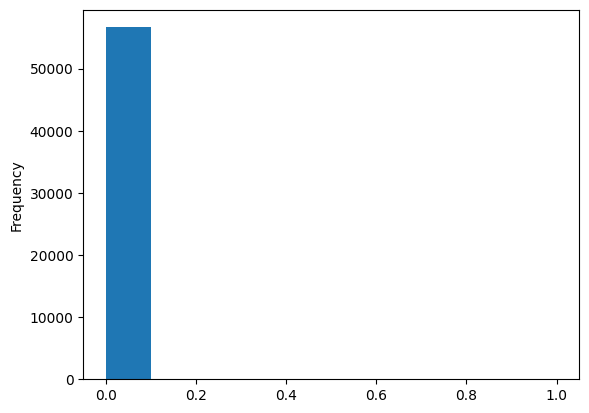

In [ ]:
print('Test set:')
attributes = pd.DataFrame(X_test)
labels = pd.Series(y_test, name='class')
df_test = pd.concat([attributes, labels], axis=1)
freq_class = sorted(Counter(df_test['class']).items())
print('Frequencias ',freq_class)
df_test['class'].plot.hist()

## SMOTE

> Synthetic Minority Oversampling Technique é uma estratégia de oversampling baseada em vizinhos mais próximos para selecionar os objetos  a serem amostrados.

In [ ]:
from imblearn.over_sampling import SMOTE, BorderlineSMOTE

smote = BorderlineSMOTE(k_neighbors=3,m_neighbors=2,sampling_strategy='minority')
X_smote, y_smote = smote.fit_resample(X_train, y_train)

SMOTE set:
0    226597
1    226597
Name: Class, dtype: int64


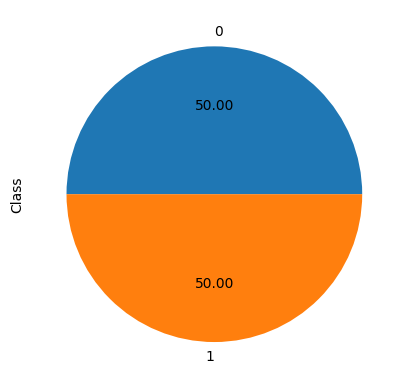

In [ ]:
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

df_balanceado = X_smote.copy()
df_balanceado['Class'] = y_smote.copy()


class_counts = df_balanceado["Class"].value_counts()
class_counts.plot.pie(autopct="%.2f")

print('SMOTE set:')
print(class_counts)

## Isolation Forest

> O algoritmo Isolation Forest é baseado no princípio que as anomalias são poucas e diferentes, o que as torna fáceis de identificar. Isto é utilizado para encontrar pontos de anomalia isolados.

### Com SMOTE


In [ ]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest(n_estimators=100,
                      contamination=0.5,
                      max_samples=300,
                      random_state=42,
                      warm_start=True)

clf.fit(df_balanceado.drop('Class', axis=1))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.5, max_samples=300, random_state=42,
                warm_start=True)

In [ ]:
df_balanceado_copy = df_balanceado.copy()
df_balanceado_copy['out_scores'] = clf.decision_function(df_balanceado.drop('Class', axis=1))
df_balanceado_copy['anomaly']=clf.predict(df_balanceado.drop(['Class'], axis=1))
df_balanceado_copy[df_balanceado_copy['Class'] == 1].head(20)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,out_scores,anomaly
392,152307.0,-5.222968,4.641827,-8.858204,7.723502,-1.507035,-2.159484,-4.205164,0.979334,-1.505637,...,0.536429,-0.628334,-0.222651,0.382208,-2.693036,0.407935,1.00,1,-0.034163,-1
560,101313.0,-25.825982,19.167239,-25.390229,11.125435,-16.682644,3.933699,-37.060311,-28.759799,-11.126624,...,3.510019,0.054330,-0.671983,-0.209431,-4.950022,-0.448413,2.28,1,-0.258837,-1
986,153761.0,1.146259,1.403458,-4.159148,2.660107,-0.323217,-1.836071,-1.623740,0.259562,-1.132044,...,-0.141136,-0.265517,0.362260,-0.416062,0.507370,0.243744,51.37,1,0.014002,1
1450,88672.0,-3.859881,2.632881,-5.264265,3.446113,-0.675231,-1.904959,-3.291041,-0.985766,-1.168114,...,0.068412,0.778961,-0.863166,-0.006810,-1.065734,1.773326,1.18,1,-0.044647,-1
1594,93965.0,-11.397727,7.763953,-18.572307,6.711855,-10.174216,-4.395918,-15.893788,2.083013,-4.988837,...,0.239217,0.534644,-0.174965,-0.500240,-1.722060,-0.574339,11.40,1,-0.090501,-1
1681,129668.0,0.753356,2.284988,-5.164492,3.831112,-0.073622,-1.316596,-1.855495,0.831079,-1.567514,...,0.187697,0.358433,-0.488934,-0.258802,0.296145,-0.047174,2.00,1,0.008471,1
1735,141925.0,0.120301,1.974141,-0.434087,5.390793,1.289684,0.280590,0.221963,0.067827,-1.387054,...,-0.167313,0.791547,-0.223675,0.473223,-0.160202,0.065039,0.76,1,0.005404,1
2488,123078.0,-1.073820,0.415616,-2.273977,1.536844,-0.758697,-1.670381,-2.377140,0.090370,0.004847,...,0.450743,-0.144228,-0.205609,-0.539073,0.503418,-0.237807,11.00,1,0.002022,1
3399,56098.0,-1.229669,1.956099,-0.851198,2.796987,-1.913977,-0.044934,-1.340739,-0.555548,-1.184468,...,0.019266,0.508529,-0.201183,-0.249600,0.562239,0.075309,170.92,1,0.003067,1
4466,21419.0,-17.467710,10.114816,-24.202142,11.805469,-10.198046,-2.579938,-17.656788,2.256902,-6.242149,...,1.296817,-1.055104,0.111792,0.679695,2.093541,-1.425491,1.00,1,-0.158326,-1


In [ ]:
freq_class = sorted(Counter(df_balanceado['Class']).items())
print('Frequencias ',freq_class)
qtd_outliers = len(df_balanceado_copy[df_balanceado_copy['anomaly'] == -1])
print('QTD-Outliers',qtd_outliers)
df_balanceado_copy[df_balanceado_copy['anomaly'] == -1].head(20)

Frequencias  [(0, 226597), (1, 226597)]
QTD-Outliers 226514


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,out_scores,anomaly
0,57873.0,-1.353894,-1.081034,1.787587,-1.803254,-0.235223,2.177295,1.014795,0.549627,0.629906,...,0.805029,-0.981966,-0.783392,0.905245,-0.176870,-0.093081,318.00,0,-0.055679,-1
12,41052.0,-15.319964,-15.126137,-0.856656,3.192933,3.495020,-1.472074,1.447344,-1.839068,3.440986,...,5.576888,0.003408,2.332782,1.099939,-2.814695,7.341635,139.51,0,-0.138241,-1
23,148396.0,-5.844837,3.253667,-1.548830,-2.591589,-2.809063,-0.089265,-2.603182,2.567635,2.058279,...,0.376628,-0.778057,0.501979,-0.335510,-0.600106,-0.829995,1.00,0,-0.045062,-1
28,1674.0,0.248077,-3.034369,-0.723430,-0.867091,-1.704896,-0.279698,0.119744,-0.350269,-2.223878,...,-0.722614,0.070441,0.473897,-0.132890,-0.107444,0.111013,668.04,0,-0.005532,-1
38,160869.0,-4.664634,4.643700,-3.763153,-1.865628,-0.592978,-1.686038,0.157636,1.459756,1.355339,...,0.030151,-0.319615,0.515634,0.103426,0.904696,0.369441,7.69,0,-0.008731,-1
40,139939.0,1.238430,-2.036681,-2.734274,-0.411554,0.406066,0.731884,0.569748,-0.116113,-1.223385,...,-0.353153,-1.547590,-0.067195,0.891498,-0.132662,-0.029767,453.28,0,-0.035429,-1
41,102830.0,-2.092102,-1.964895,-1.800097,-1.523974,1.018891,-0.751273,3.474997,-0.786021,0.651051,...,1.094711,0.093503,1.348381,0.638036,-0.313148,0.145566,690.78,0,-0.058300,-1
59,87772.0,-2.434945,2.282860,-0.205347,-2.431283,-0.755116,-2.222820,0.616720,0.583152,0.612092,...,0.158149,0.920227,0.100124,0.341088,0.505275,0.351469,5.00,0,-0.006257,-1
66,56628.0,-5.668006,4.625185,-3.825956,-1.724182,-2.511080,-0.017168,-3.411191,4.707750,-1.251212,...,0.360421,-1.655526,0.211230,0.826937,-1.764892,-0.366687,0.77,0,-0.074472,-1
69,39824.0,-0.021944,0.713192,0.458627,0.046747,0.398278,1.585721,-1.121381,-2.385478,-0.357952,...,-0.251900,-1.254876,0.890992,0.533742,0.090916,0.217966,1.00,0,-0.020333,-1


### Sem SMOTE

In [ ]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest(n_estimators=100,
                      contamination=0.01,
                      max_samples=300,
                      random_state=42,
                      warm_start=True)

clf.fit(df_train.drop('Class', axis=1))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.01, max_samples=300, random_state=42,
                warm_start=True)

In [ ]:
df_train_copy = df_train.copy()
df_train_copy['out_scores'] = clf.decision_function(df_train.drop('Class', axis=1))
df_train_copy['anomaly']=clf.predict(df_train.drop(['Class'], axis=1))
df_train_copy[df_train_copy['Class'] == 1].head(20)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,out_scores,anomaly
244333,152307.0,-5.222968,4.641827,-8.858204,7.723502,-1.507035,-2.159484,-4.205164,0.979334,-1.505637,...,0.536429,-0.628334,-0.222651,0.382208,-2.693036,0.407935,1.00,1,-0.041248,-1
154371,101313.0,-25.825982,19.167239,-25.390229,11.125435,-16.682644,3.933699,-37.060311,-28.759799,-11.126624,...,3.510019,0.054330,-0.671983,-0.209431,-4.950022,-0.448413,2.28,1,-0.147423,-1
247995,153761.0,1.146259,1.403458,-4.159148,2.660107,-0.323217,-1.836071,-1.623740,0.259562,-1.132044,...,-0.141136,-0.265517,0.362260,-0.416062,0.507370,0.243744,51.37,1,0.070082,1
147548,88672.0,-3.859881,2.632881,-5.264265,3.446113,-0.675231,-1.904959,-3.291041,-0.985766,-1.168114,...,0.068412,0.778961,-0.863166,-0.006810,-1.065734,1.773326,1.18,1,-0.053911,-1
150715,93965.0,-11.397727,7.763953,-18.572307,6.711855,-10.174216,-4.395918,-15.893788,2.083013,-4.988837,...,0.239217,0.534644,-0.174965,-0.500240,-1.722060,-0.574339,11.40,1,-0.107006,-1
192382,129668.0,0.753356,2.284988,-5.164492,3.831112,-0.073622,-1.316596,-1.855495,0.831079,-1.567514,...,0.187697,0.358433,-0.488934,-0.258802,0.296145,-0.047174,2.00,1,0.028072,1
219892,141925.0,0.120301,1.974141,-0.434087,5.390793,1.289684,0.280590,0.221963,0.067827,-1.387054,...,-0.167313,0.791547,-0.223675,0.473223,-0.160202,0.065039,0.76,1,0.122160,1
177195,123078.0,-1.073820,0.415616,-2.273977,1.536844,-0.758697,-1.670381,-2.377140,0.090370,0.004847,...,0.450743,-0.144228,-0.205609,-0.539073,0.503418,-0.237807,11.00,1,0.050432,1
75511,56098.0,-1.229669,1.956099,-0.851198,2.796987,-1.913977,-0.044934,-1.340739,-0.555548,-1.184468,...,0.019266,0.508529,-0.201183,-0.249600,0.562239,0.075309,170.92,1,0.049599,1
12261,21419.0,-17.467710,10.114816,-24.202142,11.805469,-10.198046,-2.579938,-17.656788,2.256902,-6.242149,...,1.296817,-1.055104,0.111792,0.679695,2.093541,-1.425491,1.00,1,-0.124063,-1


In [ ]:
freq_class = sorted(Counter(df_train['Class']).items())
print('Frequencias ',freq_class)
qtd_outliers = len(df_train_copy[df_train_copy['anomaly'] == -1])
print('QTD-Outliers',qtd_outliers)
df_train_copy[df_train_copy['anomaly'] == -1].head(20)

Frequencias  [(0, 226597), (1, 383)]
QTD-Outliers 2270


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,out_scores,anomaly
42317,41052.0,-15.319964,-15.126137,-0.856656,3.192933,3.495020,-1.472074,1.447344,-1.839068,3.440986,...,5.576888,0.003408,2.332782,1.099939,-2.814695,7.341635,139.51,0,-0.042411,-1
31471,36380.0,-2.328885,-1.249252,-2.307229,0.396004,-6.946031,5.526407,9.658528,-1.361005,-0.994627,...,1.013616,-1.268916,0.999212,-0.281767,0.748928,-0.421530,2043.00,0,-0.010546,-1
244333,152307.0,-5.222968,4.641827,-8.858204,7.723502,-1.507035,-2.159484,-4.205164,0.979334,-1.505637,...,0.536429,-0.628334,-0.222651,0.382208,-2.693036,0.407935,1.00,1,-0.041248,-1
12878,22630.0,-3.392394,-3.424291,0.593767,0.516664,-4.900881,2.363086,5.245160,-0.289834,1.039260,...,3.285282,-0.198027,0.883308,0.452480,-0.298304,0.233716,1555.23,0,-0.023849,-1
172117,120966.0,-5.722107,3.888832,-4.712097,-0.067071,-2.783175,-1.618323,-2.648370,3.600388,-0.759479,...,0.568305,-0.113832,-0.643970,-0.379285,-2.844925,-0.594558,0.89,0,-0.001212,-1
154371,101313.0,-25.825982,19.167239,-25.390229,11.125435,-16.682644,3.933699,-37.060311,-28.759799,-11.126624,...,3.510019,0.054330,-0.671983,-0.209431,-4.950022,-0.448413,2.28,1,-0.147423,-1
6306,7447.0,-5.726395,1.071792,0.662783,-0.077759,0.303239,1.957196,0.784972,-0.800449,4.150725,...,-0.291276,-0.948467,-0.589127,-1.016799,-6.126486,-2.372644,3.00,0,-0.018783,-1
141123,84136.0,-3.360756,1.426083,-1.032368,3.466782,-9.994100,8.244267,5.452578,-6.476317,-0.886449,...,-0.650739,0.235769,0.094357,0.419342,2.038678,-1.018021,1868.88,0,-0.031158,-1
152936,97623.0,-1.825892,-5.839373,-1.172461,5.400981,-2.353924,1.736267,1.298039,-0.133386,0.857273,...,-1.432411,-0.337946,-1.203602,-0.268376,-0.338807,0.291309,1888.43,0,-0.019024,-1
230890,146524.0,-3.076273,3.621097,-1.148812,3.511543,-0.712766,4.510985,-4.218870,-13.236080,-2.566870,...,0.649444,-1.140559,-0.808306,0.541941,0.605697,0.087281,182.06,0,-0.015493,-1


## ONE-CLASS SVM

> One-Class Support Vector Machine (SVM) é um modelo não supervisionado para detecção de anomalias ou outliers. Diferentemente de um SVM supervisionado, o One-Class não possui labels alvos para o modelo de processo de treinamento. Em vez disso, ele aprende através das bordas no pontos normais e identifica as anomalias fora desse contexto.

In [ ]:
from sklearn import linear_model
from sklearn.svm import OneClassSVM

clf = linear_model.SGDOneClassSVM(nu=0.01,
                  eta0=0.001)

clf.fit(df_train.drop('Class', axis=1))

SGDOneClassSVM(eta0=0.001, nu=0.01)

In [ ]:
df_train_copy = df_train.copy()
df_train_copy['out_scores'] = clf.score_samples(df_train.drop('Class', axis=1))
df_train_copy['anomaly']=clf.predict(df_train.drop(['Class'], axis=1))
df_train_copy[df_train_copy['Class'] == 1].head(20)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,out_scores,anomaly
244333,152307.0,-5.222968,4.641827,-8.858204,7.723502,-1.507035,-2.159484,-4.205164,0.979334,-1.505637,...,0.536429,-0.628334,-0.222651,0.382208,-2.693036,0.407935,1.00,1,1.560475e+06,1
154371,101313.0,-25.825982,19.167239,-25.390229,11.125435,-16.682644,3.933699,-37.060311,-28.759799,-11.126624,...,3.510019,0.054330,-0.671983,-0.209431,-4.950022,-0.448413,2.28,1,1.038012e+06,1
247995,153761.0,1.146259,1.403458,-4.159148,2.660107,-0.323217,-1.836071,-1.623740,0.259562,-1.132044,...,-0.141136,-0.265517,0.362260,-0.416062,0.507370,0.243744,51.37,1,1.575378e+06,1
147548,88672.0,-3.859881,2.632881,-5.264265,3.446113,-0.675231,-1.904959,-3.291041,-0.985766,-1.168114,...,0.068412,0.778961,-0.863166,-0.006810,-1.065734,1.773326,1.18,1,9.084972e+05,1
150715,93965.0,-11.397727,7.763953,-18.572307,6.711855,-10.174216,-4.395918,-15.893788,2.083013,-4.988837,...,0.239217,0.534644,-0.174965,-0.500240,-1.722060,-0.574339,11.40,1,9.627282e+05,1
192382,129668.0,0.753356,2.284988,-5.164492,3.831112,-0.073622,-1.316596,-1.855495,0.831079,-1.567514,...,0.187697,0.358433,-0.488934,-0.258802,0.296145,-0.047174,2.00,1,1.328526e+06,1
219892,141925.0,0.120301,1.974141,-0.434087,5.390793,1.289684,0.280590,0.221963,0.067827,-1.387054,...,-0.167313,0.791547,-0.223675,0.473223,-0.160202,0.065039,0.76,1,1.454106e+06,1
177195,123078.0,-1.073820,0.415616,-2.273977,1.536844,-0.758697,-1.670381,-2.377140,0.090370,0.004847,...,0.450743,-0.144228,-0.205609,-0.539073,0.503418,-0.237807,11.00,1,1.261008e+06,1
75511,56098.0,-1.229669,1.956099,-0.851198,2.796987,-1.913977,-0.044934,-1.340739,-0.555548,-1.184468,...,0.019266,0.508529,-0.201183,-0.249600,0.562239,0.075309,170.92,1,5.747768e+05,1
12261,21419.0,-17.467710,10.114816,-24.202142,11.805469,-10.198046,-2.579938,-17.656788,2.256902,-6.242149,...,1.296817,-1.055104,0.111792,0.679695,2.093541,-1.425491,1.00,1,2.194504e+05,1


In [ ]:
freq_class = sorted(Counter(df_train['Class']).items())
print('Frequencias ',freq_class)
qtd_outliers = len(df_train_copy[df_train_copy['anomaly'] == -1])
print('QTD-Outliers',qtd_outliers)
df_train_copy[df_train_copy['anomaly'] == -1].head(20)

Frequencias  [(0, 226597), (1, 383)]
QTD-Outliers 1


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,out_scores,anomaly
1,0.0,1.191857,0.266151,0.16648,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,0.101288,-0.339846,0.16717,0.125895,-0.008983,0.014724,2.69,0,0.314148,-1
